# Project 2: Continuous Control
### Test 1 - DDPG model

<sub>Uirá Caiado. October 07, 2018<sub>

#### Abstract

_In this notebook, I will use the Unity ML-Agents environment to train a DDPG model for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893)._


## 1. What we are going to test

We begin by checking if the necessary packages are presented. If the code cell below returns an error, please check if you have all the packages required in the README of this project.

In [1]:
%load_ext version_information
%version_information numpy, unityagents, torch, matplotlib, pandas

Software versions
Python 3.6.6 64bit [MSC v.1900 64 bit (AMD64)]
IPython 7.0.1
OS Windows 10 10.0.17134 SP0
numpy 1.15.2
unityagents 0.4.0
torch 0.4.1
matplotlib 3.0.0
pandas 0.23.4
Sat Oct 13 01:31:26 2018 Hora oficial do Brasil

Now, let's define some meta variables to use in this notebook

In [3]:
import os
fig_prefix = 'figures/2018-10-07-'
data_prefix = '../data/2018-10-07-'
s_currentpath = os.getcwd()

Finally, let's import some of the necessary packages for this experiment.

In [4]:
import sys
import os
sys.path.append("../")  # include the root directory as the main
import eda
import pandas as pd
import numpy as np

## 2. Exploring the Environment

The environment used for this project is the Reacher environment, from [Unity](https://youtu.be/heVMs3t9qSk). Bellow, we are going to start this environment.

In [5]:
from drlnd import make, DDPG, DDPG_PARAMS

In [6]:
env = make()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the brain we will be controlling from Python.

In [7]:
# get the default brain
env.brain_name
brain = env.brain

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Let's check some information about the environment below.

In [8]:
# reset the environment
states = env.reset()

# number of agents
print('Number of agents:', env.num_agents)

# size of each action
print('Size of each action:', env.action_size)

# examine the state space 
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


## 3. Training the Agent

Let's use the Python API to control the agent and receive feedback from the environment.The idea is to make the agent use its experience to gradually choose better actions when interacting with the environment. First, lest's check the agent's parameters.

In [9]:
print(DDPG_PARAMS)

                               DDPG PARAMETERS                                
BUFFER_SIZE                    100000   LR_ACTOR                        0.0001
BATCH_SIZE                        200   LR_CRITIC                        0.001
GAMMA                            0.99   WEIGHT_DECAY                    0.0001
TAU                             0.001   UPDATE_EVERY                         2


Now, we are going to train the agent for 250 episodes or until it reaches an average score of 30 over 100 enpisodes and agents. 

In [10]:
%%time
from collections import deque
import pickle
import torch

episodes = 2
rand_seed = 0

scores = []
scores_std = []
scores_avg = []
scores_window = deque(maxlen=100)

agent = DDPG(env.state_size, env.action_size, env.num_agents, rand_seed)

SOLVED = False

print('\nNN ARCHITECURES:')
print(agent.actor_local)
print(agent.critic_local)

print('\nTRAINING:')
for episode in range(episodes):
    states = env.reset()
    score = 0.
    for i in range(1000):
        actions = agent.act(states, add_noise=True)
        next_states, rewards, dones = env.step(actions)
        agent.step(states, actions, rewards, next_states, dones)
        score += np.mean(rewards)
        states = next_states
        if np.any(dones):
            break

    scores.append(score)
    scores_window.append(score)
    scores_avg.append(np.mean(scores_window))
    scores_std.append(np.std(scores_window))
    s_msg = '\rEpisode {}\tAverage Score: {:.2f}\tσ: {:.2f}\tScore: {:.2f}'
    print(s_msg.format(episode, np.mean(scores_window),
                       np.std(scores_window), score), end="")
    if episode % 10 == 0:
        print(s_msg.format(episode, np.mean(scores_window),
                           np.std(scores_window), score))
    if np.mean(scores_window) >= 30:
        SOLVED = True
        s_msg = '\n\nEnvironment solved in {:d} episodes!\tAverage '
        s_msg += 'Score: {:.2f}\tσ: {:.2f}'
        print(s_msg.format(episode, np.mean(scores_window),
                           np.std(scores_window)))
        # save the models
        s_aux = '%scheckpoint-%s.%s.pth'
        s_actor_path = s_aux % (data_prefix, agent.__name__, 'actor')
        s_critic_path = s_aux % (data_prefix, agent.__name__, 'critic')
        torch.save(agent.actor_local.state_dict(), s_actor_path)
        torch.save(agent.critic_local.state_dict(), s_critic_path)
        break
    
# save data to use later
if not SOLVED:
    s_msg = '\n\nEnvironment not solved =/'
    print(s_msg.format(episode, np.mean(scores_window),
          np.std(scores_window)))
print('\n')
d_data = {'episodes': episode,
          'scores': scores,
          'scores_std': scores_std,
          'scores_avg': scores_avg,
          'scores_window': scores_window}
pickle.dump(d_data, open('%ssim-data-%s.data' % (data_prefix, agent.__name__), 'wb'))


NN ARCHITECURES:
Actor(
  (fc1): Linear(in_features=33, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=4, bias=True)
)
Critic(
  (fcs1): Linear(in_features=33, out_features=400, bias=True)
  (fc2): Linear(in_features=404, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=1, bias=True)
)

TRAINING:
Episode 0	Average Score: 0.56	σ: 0.00	Score: 0.56
Episode 1	Average Score: 0.74	σ: 0.18	Score: 0.92

Environment not solved =/


Wall time: 1min 16s


## 4. Results

The agent using the DDPG agent was able to solve the Reacher environment in X episodes of 1000 steps, each.

In [16]:
import pickle

d_data = pickle.load(open('%ssim-data-%s.data' % (data_prefix, model_prefix), 'rb'))
s_msg = 'Environment solved in {:d} episodes!\tAverage Score: {:.2f} +- {:.2f}'
print(s_msg.format(d_data['episodes'], np.mean(d_data['scores_window']), np.std(d_data['scores_window'])))

Environment solved in 1 episodes!	Average Score: 0.39 +- 0.10


Now, let's plot the rewards per episode. In the right panel, we will plot the rolling average score over 100 episodes $\pm$ its standard deviation, as well as the goal of this project (13+ on average over the last 100 episodes).

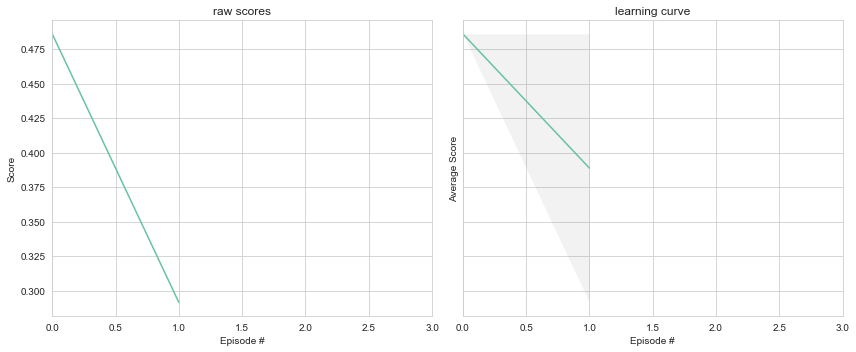

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

#recover data
na_raw = np.array(d_data['scores'])
na_mu = np.array(d_data['scores_avg'])
na_sigma = np.array(d_data['scores_std'])

# plot the scores
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# plot the sores by episode
ax1.plot(np.arange(len(na_raw)), na_raw)
ax1.set_xlim(0, len(na_raw)+1)
ax1.set_ylabel('Score')
ax1.set_xlabel('Episode #')
ax1.set_title('raw scores')

# plot the average of these scores
# ax2.axhline(y=30., xmin=0.0, xmax=1.0, color='r', linestyle='--', linewidth=0.7, alpha=0.9)
ax2.plot(np.arange(len(na_mu)), na_mu)
ax2.fill_between(np.arange(len(na_mu)), na_mu+na_sigma, na_mu-na_sigma, facecolor='gray', alpha=0.1)
ax2.set_ylabel('Average Score')
ax2.set_xlabel('Episode #')
ax2.set_title('learning curve')

f.tight_layout()

In [18]:
f.savefig(fig_prefix + '%s-learning-curve.jpg' % agent.__name__, format='jpg')

In [19]:
env.close()

## 5. Conclusion

The Deep Q-learning agent was able to solve the environment in 529 episodes. In the next experiment I will implement and test the Double Deep Q-learning model.